In [47]:
from scipy.special import gamma, factorial

In [48]:
import msprime
import tskit
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pylab
import scipy.linalg
import matplotlib
import csv
import random
from itertools import groupby
import collections

### Simulating a 1-D system where m*rho << 1 (Should take 5-10 min to run at max)

<BarContainer object of 1000 artists>

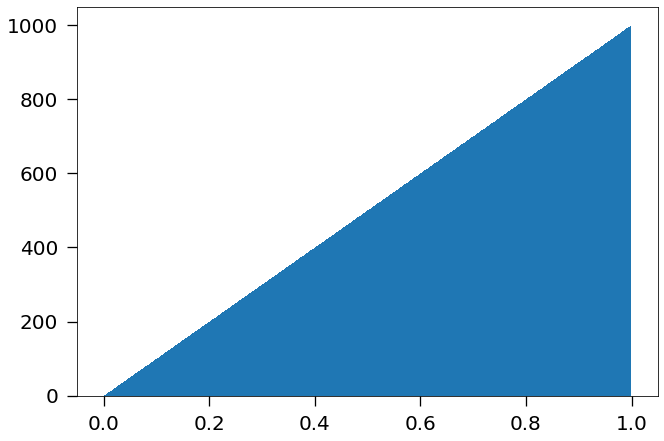

In [49]:
x_f=np.arange(1000)/1000
y=np.arange(1000)
plt.bar(x_f,y,width=1/1000)

In [50]:
plt.style.use('seaborn-talk')
matplotlib.rcParams['axes.labelsize'] = 20
matplotlib.rcParams['axes.titlesize'] = 24
matplotlib.rcParams['xtick.labelsize'] = 20
matplotlib.rcParams['xtick.major.size'] = 10
matplotlib.rcParams['xtick.minor.size'] = 5
matplotlib.rcParams['ytick.labelsize'] = 20
matplotlib.rcParams['ytick.major.size'] = 10

In [51]:
def migration_matrix(length, migration_rate):
    first_col = np.zeros(length)
    first_col[1] = migration_rate
    first_col[-1] = migration_rate
    result = scipy.linalg.circulant(first_col)
    return result

In [52]:
Deme_density = 50
L = 1000 #the number of demes 
deme_sample_size = Deme_density #deme sample size 
trials = 50 #number of trials
m = 0.2 #migration rate
total_sample_size = L * deme_sample_size # total sample size
matrix = migration_matrix(L, m/2)
total_population_size=L * Deme_density

population_configurations = L * [msprime.PopulationConfiguration(sample_size=deme_sample_size)]

print("we want 1 <<< m*deme_density <<< number of demes to keep continous structure")
print("1 <<< ",m*Deme_density," <<< ",L )
    

we want 1 <<< m*deme_density <<< number of demes to keep continous structure
1 <<<  10.0  <<<  1000


In [53]:
len(population_configurations)

1000

In [54]:
Effective_pop = L**2 / (2 * m * np.pi**2)
print("The effective population size via Maruyama equation is: ", Effective_pop)
real_pop = L*Deme_density
print("The real population size is", real_pop)

# Since we're using branch lengths, the mutation rate is 1
Theta_eff = 4 * Effective_pop
Theta_real = 4 * real_pop


The effective population size via Maruyama equation is:  253302.95910584443
The real population size is 50000


In [55]:
def smooth(x, threshold=100, rescale=2):
    return [np.mean(x[max(i - (rescale * i) // threshold, 0) : min(i + 1 + (rescale * i) // threshold, len(x))]) for i in range(len(x))]




In [56]:
transition_freq=(max(Deme_density,(m*Deme_density**2))/total_population_size)
print(transition_freq)

0.01


In [57]:
leaf_list=[[0]]
for i in range (1,total_sample_size):
    leaf_list.append([i])

In [58]:
def get_unique_numbers(numbers):

    list_of_unique_numbers = []

    unique_numbers = set(numbers)

    for number in unique_numbers:
        list_of_unique_numbers.append(number)

    return list_of_unique_numbers

iteration 0


The provenance information for the resulting tree sequence is 4.90MB. This is nothing to worry about as provenance is a good thing to have, but if you want to save this memory/storage space you can disable provenance recording by setting record_provenance=False


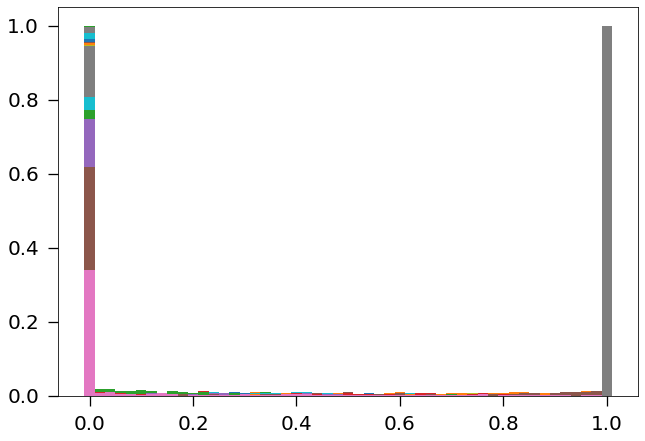

In [59]:
q=[ [0]*int(total_sample_size+1) for i in range(2*total_sample_size-1)]
afs2 = []
#a2=[]
mean_hz=[]
pooled_f=[]
for i in range(1):
    print("iteration",i)
    ts = msprime.simulate(Ne=Deme_density, population_configurations=population_configurations, migration_matrix=matrix)
   
    a=ts.mean_descendants(leaf_list) #Finds the descendants for each trial and sums them up

    afs1 = ts.allele_frequency_spectrum(mode="branch", polarised=True, span_normalise=False)
    
    afs2.append(afs1)
  

        
    #transition zone
    num_desc  = a.sum(axis=1)
    #print(num_desc)
    index_vals=[]
    count_vals=[]
    min_transition_zone=0 # transition frequency formula
    max_transition_zone=total_sample_size
    for j in range(len(num_desc)):
        if min_transition_zone<=num_desc[j]<=max_transition_zone:
            index_vals.append(j)
            count_vals.append(num_desc[j])
    #print(count_vals)        
    ######
    
    transition_desc=[]

    for i in range(len(index_vals)):
        transition_desc.append(a[int(index_vals[i])])
    #print(transition_desc)
    #print(len(transition_desc[0]))
    #print(len(transition_desc[1]))
    #np.savetxt("transition_zone_desc.csv", transition_desc , delimiter=",")
    
    ######
    
    spatial_transition = [ []*1 for i in range(len(transition_desc))]
    for r in range(len(transition_desc)):
        for t in range(len(transition_desc[r])):
            if transition_desc[r][t]>0:
                spatial_transition[r].append(t)


    #np.savetxt("spatial_transition.csv", spatial_transition ,fmt="%s", delimiter=",")
    
    ######
    
    demes=spatial_transition
    for i in range(len(demes)):
        for j in range(len(demes[i])):
            demes[i][j]=demes[i][j]//deme_sample_size # divides and rounds down to allocate into demes (0-1000)
  

    #np.savetxt("demes_transition.csv", demes ,fmt="%s", delimiter=",")
    
    
    ######
    
    #print(len(demes))
    freq=np.array(count_vals)
    #print(count_vals)
    #print(freq)
    freq=freq/(total_sample_size)
    
    #print("frequency")
    #print(freq)
    
    #print("count_vals")
    #print(count_vals)
    
    dist=np.linspace(0,len(demes)-1,len(demes)-1)
    #print(dist)

    #print(demes)
    #print(len(demes))
    ######
    base_width=[0]
    frequency=[0]
    demes_trans=[]
    for m in range(len(dist)):
        counter=collections.Counter(demes[int(dist[m])])
        z=list(counter.values())
        x=get_unique_numbers(demes[int(dist[m])])
        demes_trans.append(z)
        #print(z)
        #print(x)
        base_width.append(len(x)) 
        frequency.append(freq[int(dist[m])])
        #plt.bar(x,z,width=1.0)
        #lt.xlim(0,1000)
        #plt.xlabel("Deme Number")
        #plt.ylabel("Number of Descendants")
        #plt.title("Spatial distribution of branch of allele frequency " + str(freq[int(dist[i])]))
        #plt.figure()
        #plt.show()
        
  
        final_z=np.zeros(L)
        for k in range (len(final_z)):
            for l in range(len(x)):
                if k==x[l]:
                    final_z[k]=z[l]
        final_z=final_z/deme_sample_size
        (unique, counts) = np.unique(final_z, return_counts=True)
        frequencies = np.asarray((unique, counts)).T
        a,b=zip(*frequencies)
        b=np.array(b)
        b=b/L
        plt.bar(a,b,width=1/deme_sample_size)
        weights=np.array(b)
        f=np.array(a)
        alt_f=np.array(f)
        for p in range(len(f)):
            alt_f[p]=1-f[p]
        hetero=2*f*alt_f 
        #print(hetero)
        mean_hetero=weights*hetero   
        pooled_f.append(freq[int(dist[m])])
        mean_hz.append(sum(mean_hetero))
        #plt.title("Proportion of demes with given deme allele frequency and pooled allele frequency " + str(freq[int(dist[m])]))
        #plt.xlabel("Frequency within deme")
        #plt.ylabel("Proportion of total demes")
        #plt.figure()
        #plt.show()
  


  
    

#b=np.mean(a2,0)

#b=a/trials #Divides the sum of the  descendants by the number of trials to find the expected number of descendants per node

In [60]:
pooled_f=np.array(pooled_f)

In [61]:
a=pd.read_csv("meanhz1.csv")
len(a)
print(a)

       3.92e-05
0      0.000039
1      0.000039
2      0.000039
3      0.000039
4      0.000039
...         ...
99992  0.068439
99993  0.074650
99994  0.042046
99995  0.035158
99996  0.000000

[99997 rows x 1 columns]


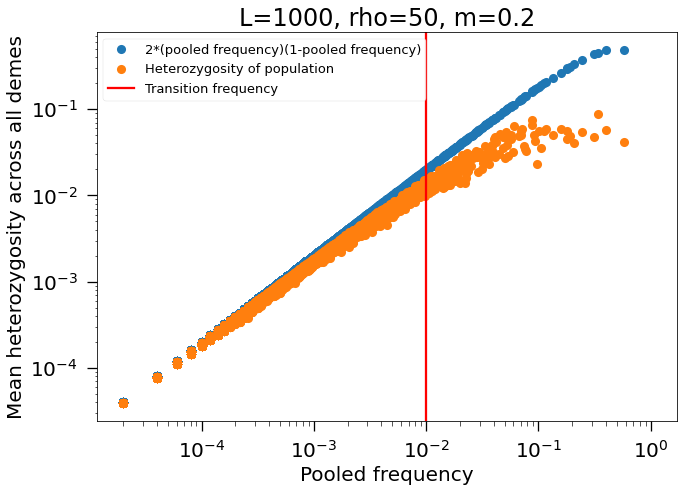

In [63]:
plt.loglog(pooled_f,2*pooled_f*(1-pooled_f),'o')
plt.loglog(pooled_f, mean_hz,'o')
plt.axvline(transition_freq,color='red')
plt.xlabel('Pooled frequency')
plt.ylabel('Mean heterozygosity across all demes')
plt.title('L=1000, rho=50, m=0.2')
plt.legend(["2*(pooled frequency)(1-pooled frequency)", "Heterozygosity of population ", 'Transition frequency'], loc ="upper left")
plt.savefig("Hetero_mrhogreat.pdf")